In [1]:
import numpy as np
import math
import matplotlib.pylab as plt
import astropy.io.fits as fits
import os
import pandas as pd
from astropy import units as u
import astroquery
from astroquery.atomic import AtomicLineList as alist
%matplotlib inline

In [3]:
filepath = "/Users/waritwij/Documents/GitHub/Przybylski_Star_v1/Sun/"

In [7]:
filelist = os.listdir(filepath)
filelist[0]

'r.HARPN.2015-07-30T12:40:51.074_S1D_A.fits'

In [11]:
hdul = fits.open(filepath + filelist[0])
hdul.info()

Filename: /Users/waritwij/Documents/GitHub/Przybylski_Star_v1/Sun/r.HARPN.2015-07-30T12:40:51.074_S1D_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     836   ()      
  1                1 BinTableHDU     24   212207R x 5C   [1D, 1D, 1D, 1D, 1J]   


In [14]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   36 / width of table in bytes                        
NAXIS2  =               212207 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'wavelength'         / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 'angstrom'           / physical unit of field                         
TTYPE2  = 'wavelength_air'     / label for field   2                            
TFORM2  = '1D      '        

In [16]:
data = hdul[1].data
data

FITS_rec([(3869.99140072, 3868.89459449, 0., 0., 16384),
          (3870.00198602, 3868.90517704, 0., 0., 16384),
          (3870.01257135, 3868.91575962, 0., 0., 16384), ...,
          (6914.8925172 , 6912.98543252, 0., 0., 16384),
          (6914.91143099, 6913.00434122, 0., 0., 16384),
          (6914.93034484, 6913.02324998, 0., 0., 16384)],
         dtype=(numpy.record, [('wavelength', '>f8'), ('wavelength_air', '>f8'), ('flux', '>f8'), ('error', '>f8'), ('quality', '>i4')]))

In [28]:
wavelength = data.field(1)
wavelength

array([3868.89459449, 3868.90517704, 3868.91575962, ..., 6912.98543252,
       6913.00434122, 6913.02324998])

In [27]:
sunSpectrum = data.field(2)
sunSpectrum

array([0., 0., 0., ..., 0., 0., 0.])

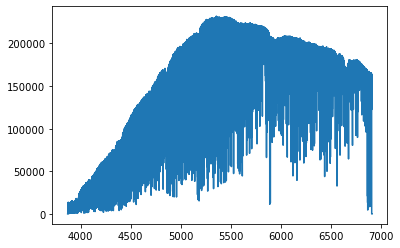

In [31]:
plt.plot(wavelength, sunSpectrum)

In [30]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-08-25T21:25:48' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
VERSION =               120203 / Application parameter value                    
DWELL   =               300000 / Application parameter value                    
RD_TIME =                    0 / Application parameter value                    
RS_TIME =                  383 / Application parameter value                    
FRM_TYPE=                    1 / Application parameter value                    
NUM_EXPS=                   

In [39]:
def plotWavelength(wavelength, spectralArr, specLambda, lambdaRange):
    plt.plot(wavelength, spectralArr)
    plt.grid(True)
    plt.xlim(specLambda-lambdaRange/2, specLambda+lambdaRange/2)
    plt.title(str(specLambda)+" Å")
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.vlines(specLambda, ymin = 0, ymax = 200000)
    plt.show()

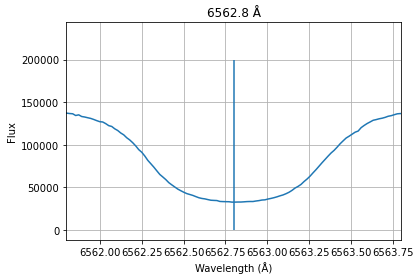

In [41]:
plotWavelength(wavelength, sunSpectrum, 6562.8, 2)
#function test

In [48]:
def isline(wavelength, spectrum, wl, wlrange):
    wlList = np.array(wavelength)
    spectrumList = np.array(spectrum)
    indexclosest = np.argmin(np.abs(wlList - wl))
    plt.plot(wavelength, spectrum)
    index1 = index2 = indexclosest
    while spectrum[index1] <= np.median(spectrumList[np.where((wavelength > wl-wlrange/2) & (wavelength < wl+wlrange/2))]):
        plt.plot([wavelength[index1]], [spectrum[index1]], 'ro')
        index1 += 1
    while spectrum[index2] <= np.median(spectrumList[np.where((wavelength > wl-wlrange/2) & (wavelength < wl+wlrange/2))]):
        plt.plot([wavelength[index2]], [spectrum[index2]], 'ro')
        index2 -= 1
    plt.grid(True)
    plt.xlim(wl-wlrange/2, wl+wlrange/2)
    plt.title(str(wl)+" Å")
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Intensity')
    plt.vlines(wl, ymin = 0, ymax = 14000)
    plt.show()

NameError: name 'spectArrA' is not defined

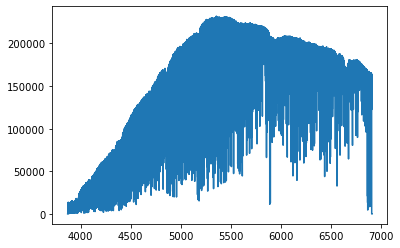

In [46]:
isline(wavelength, sunSpectrum, 5000.2109, 1)